<a href="https://colab.research.google.com/github/cakirataberk/msc_2025_ataberkcakir_thesis/blob/main/EBM_on_Synthetic_Data_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title EBM on Synthetic Data: Validation & Benchmarking Notebook
# @markdown #EBM on Synthetic Data: Validation & Benchmarking Notebook
# @markdown This notebook is designed to rigorously test the from-scratch Explainable Boosting Machine (EBM) implementation on synthetic datasets where the ground truth is known. The primary goals are:
# @markdown 1.  **Validate Correctness:** Ensure the model can accurately recover known main effects and interaction terms.
# @markdown 2.  **Benchmark Performance:** Quantitatively measure the model's ability to identify the correct hierarchy of feature and interaction importances.
# @markdown 3.  **Stress-Test Robustness:** Evaluate the model under more challenging conditions, such as with correlated features.
# @markdown
# @markdown The notebook is structured as follows:
# @markdown * **Section 1:** Finalized EBM Implementation Code
# @markdown * **Section 2:** Synthetic Dataset Generation Functions
# @markdown * **Section 3:** Benchmarking and Performance Testing
# @markdown ---

# @markdown ## Section 1: Finalized EBM Implementation Code
# @markdown This section contains the complete, self-contained code for the `ScratchEBM` and `ScratchEBMWithBagging` classes. [cite_start]These are the final, robust versions developed previously. [cite: 1]

# @markdown ### 1.1 Necessary Imports

In [2]:
!pip install SALib &> /dev/null

In [3]:
!pip install interpret &> /dev/null

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from interpret.glassbox import ExplainableBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_friedman1
from sklearn.metrics import mean_squared_error
import itertools
import time

# For ground truth analysis
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami, Sobol_G

In [5]:

# @markdown ### 1.2 The Base `ScratchEBM` Class
# [cite_start]@markdown The core engine that learns main effects (shape functions) using the "fast" algorithm and then greedily discovers pairwise interactions. [cite: 1]


In [6]:
class ScratchEBM:
    """
    The core EBM engine. This final version includes the fast stump learner and
    corrects the interaction gain calculation.
    """
    def __init__(self, n_estimators=2000, learning_rate=0.01, max_bins=1024,
                 min_samples_leaf=4, interactions=0, model_type='regression'):
        self.n_estimators, self.learning_rate, self.max_bins, self.min_samples_leaf, self.interactions, self.model_type = \
        n_estimators, learning_rate, max_bins, min_samples_leaf, interactions, model_type

        self.intercept_ = 0
        self.bin_edges_ = []
        self.feature_shapes_ = []
        self.feature_names_ = []
        self.interaction_terms_ = []
        self.interaction_models_ = []

    def _discretize(self, X):
        n_features = X.shape[1]
        self.bin_edges_ = [None] * n_features
        X_binned = np.zeros_like(X, dtype=int)
        for i in range(n_features):
            _, self.bin_edges_[i] = np.histogram(X[:, i], bins=self.max_bins)
            X_binned[:, i] = np.digitize(X[:, i], self.bin_edges_[i][1:-1])
        return X_binned

    def _fast_stump_learner(self, y, X_binned_feature):
        best_gain, best_split_bin = -np.inf, -1
        bin_sums, bin_counts = np.zeros(self.max_bins), np.zeros(self.max_bins)
        np.add.at(bin_sums, X_binned_feature, y)
        np.add.at(bin_counts, X_binned_feature, 1)

        total_sum, total_count = bin_sums.sum(), bin_counts.sum()
        current_left_sum, current_left_count = 0, 0

        for i in range(self.max_bins - 1):
            current_left_sum += bin_sums[i]
            current_left_count += bin_counts[i]
            if current_left_count < self.min_samples_leaf: continue
            current_right_count = total_count - current_left_count
            if current_right_count < self.min_samples_leaf: break

            gain = (current_left_sum**2 / current_left_count) + ((total_sum - current_left_sum)**2 / current_right_count)
            if gain > best_gain:
                best_gain, best_split_bin = gain, i

        if best_split_bin == -1: return np.zeros(self.max_bins)
        update = np.zeros(self.max_bins)
        left_indices = np.arange(self.max_bins) <= best_split_bin
        right_indices = ~left_indices
        left_sum, left_count = bin_sums[left_indices].sum(), bin_counts[left_indices].sum()
        right_sum, right_count = bin_sums[right_indices].sum(), bin_counts[right_indices].sum()
        update[left_indices] = left_sum / left_count if left_count > 0 else 0
        update[right_indices] = right_sum / right_count if right_count > 0 else 0
        return update

    def fit(self, X, y, X_binned=None, bin_edges=None, feature_names=None):
        if feature_names is not None:
            self.feature_names_ = feature_names
        elif hasattr(X, 'columns'):
            self.feature_names_ = X.columns
        else:
            self.feature_names_ = [f'feature_{i}' for i in range(X.shape[1])]

        n_features = X.shape[1]
        if X_binned is None: X_binned = self._discretize(X)
        self.bin_edges_ = bin_edges if bin_edges is not None else self.bin_edges_

        self.intercept_ = np.mean(y)
        residuals = y.copy() - self.intercept_
        self.feature_shapes_ = [np.zeros(self.max_bins) for _ in range(n_features)]

        for _ in range(self.n_estimators):
            for j in range(n_features):
                update = self._fast_stump_learner(residuals, X_binned[:, j])
                self.feature_shapes_[j] += self.learning_rate * update
                residuals -= self.learning_rate * update[X_binned[:, j]]

        if self.interactions > 0:
            candidate_pairs = list(itertools.combinations(range(n_features), 2))
            print(f"Finding {self.interactions} interaction(s)...")
            for i in range(self.interactions):
                best_pair, best_model, best_gain = None, None, np.inf
                for pair in candidate_pairs:
                    j1, j2 = pair
                    tree = DecisionTreeRegressor(max_depth=4, min_samples_leaf=self.min_samples_leaf)
                    tree.fit(X[:, [j1, j2]], residuals)
                    preds = tree.predict(X[:, [j1, j2]])
                    current_sse = np.sum((residuals - preds)**2)
                    if current_sse < best_gain:
                        best_gain, best_pair, best_model = current_sse, pair, tree

                if best_pair is not None:
                    print(f"Interaction {i+1}: {self.feature_names_[best_pair[0]]} & {self.feature_names_[best_pair[1]]}")
                    self.interaction_terms_.append(best_pair)
                    self.interaction_models_.append(best_model)
                    candidate_pairs.remove(best_pair)
                    residuals -= self.learning_rate * best_model.predict(X[:, [best_pair[0], best_pair[1]]])
                else:
                    break

    def predict(self, X):
        preds = np.full(X.shape[0], self.intercept_)
        X_binned = np.zeros((X.shape[0], X.shape[1]), dtype=int)
        for i in range(X.shape[1]):
             X_binned[:, i] = np.digitize(X[:, i], self.bin_edges_[i][1:-1])

        for i in range(X.shape[1]):
            preds += self.feature_shapes_[i][X_binned[:, i]]

        for pair, model in zip(self.interaction_terms_, self.interaction_models_):
            j1, j2 = pair
            preds += self.learning_rate * model.predict(X[:, [j1, j2]])

        return preds



In [7]:
# @markdown ### 1.3 The `ScratchEBMWithBagging` Wrapper Class
# [cite_start]@markdown This class implements the robust bagging architecture: stabilize main effects first via bagging, then find interactions once on the cleaned residuals. [cite: 1]

In [8]:
class ScratchEBMWithBagging:
    """
    A wrapper class that correctly uses bagging to stabilize main effects before
    finding interaction terms once on the stabilized residuals.
    """
    def __init__(self, ebm_params, outer_bags=8):
        self.ebm_params = ebm_params
        self.outer_bags = outer_bags
        self.final_model = ScratchEBM(**self.ebm_params)

    def fit(self, X, y, feature_names=None):
        n_samples, n_features = X.shape

        print("Creating consistent binning for all models...")
        temp_ebm = ScratchEBM(**self.ebm_params)
        X_binned_full = temp_ebm._discretize(X)
        self.final_model.bin_edges_ = temp_ebm.bin_edges_

        if feature_names is not None:
            self.final_model.feature_names_ = feature_names
        elif hasattr(X, 'columns'):
            self.final_model.feature_names_ = X.columns
        else:
            self.final_model.feature_names_ = [f'feature_{i}' for i in range(n_features)]

        bagged_main_effects = []
        base_params_main_only = self.ebm_params.copy()
        base_params_main_only['interactions'] = 0

        for i in range(self.outer_bags):
            print(f"--- Training Main Effects in Bag {i+1}/{self.outer_bags} ---")
            indices = np.random.choice(n_samples, n_samples, replace=True)
            model = ScratchEBM(**base_params_main_only)
            model.fit(
                X[indices], y[indices],
                X_binned=X_binned_full[indices],
                bin_edges=self.final_model.bin_edges_,
                feature_names=self.final_model.feature_names_
            )
            bagged_main_effects.append(model.feature_shapes_)

        self.final_model.feature_shapes_ = np.mean(bagged_main_effects, axis=0)
        self.final_model.intercept_ = np.mean(y)

        main_effect_preds = np.full(n_samples, self.final_model.intercept_)
        for i in range(n_features):
            main_effect_preds += self.final_model.feature_shapes_[i][X_binned_full[:, i]]

        residuals = y - main_effect_preds

        if self.final_model.interactions > 0:
            print("\n--- Finding Interactions on Stabilized Residuals ---")
            candidate_pairs = list(itertools.combinations(range(n_features), 2))
            for i in range(self.final_model.interactions):
                best_pair, best_model, best_gain = None, None, np.inf
                for pair in candidate_pairs:
                    j1, j2 = pair
                    tree = DecisionTreeRegressor(max_depth=3, min_samples_leaf=self.final_model.min_samples_leaf)
                    tree.fit(X[:, [j1, j2]], residuals)
                    preds = tree.predict(X[:, [j1, j2]])
                    current_sse = np.sum((residuals - preds)**2)
                    if current_sse < best_gain:
                         best_gain, best_pair, best_model = current_sse, pair, tree

                if best_pair is not None:
                    print(f"Interaction {i+1}: {self.final_model.feature_names_[best_pair[0]]} & {self.final_model.feature_names_[best_pair[1]]}")
                    self.final_model.interaction_terms_.append(best_pair)
                    self.final_model.interaction_models_.append(best_model)
                    candidate_pairs.remove(best_pair)
                    residuals -= self.final_model.learning_rate * best_model.predict(X[:, [best_pair[0], best_pair[1]]])
                else:
                    break
        return self

    def predict(self, X):
        return self.final_model.predict(X)


In [9]:

# @markdown ---
# @markdown ## Section 2: Synthetic Dataset Generation
# @markdown This section provides functions to generate the synthetic datasets. Each function has a known structure, including specific main effects and interactions, allowing us to treat them as a ground truth for model validation.

# @markdown ### 2.1 Helper Function for Plotting

In [10]:
def plot_shape_functions(ebm_model, ground_truth_fns=None, feature_names=None):
    """Plots the learned shape functions against optional ground truth functions."""
    # Determine the number of features to iterate over for plotting
    if feature_names is None:
        n_plots = len(ebm_model.final_model.feature_shapes_)
        # Use the model's feature names if none are explicitly provided
        effective_feature_names = ebm_model.final_model.feature_names_ if hasattr(ebm_model.final_model, 'feature_names_') and ebm_model.final_model.feature_names_ else [f'feature_{i}' for i in range(n_plots)]
        feature_indices_to_use = list(range(n_plots)) # Plot all features in model order
    else:
        # If feature_names are provided, we plot only those.
        effective_feature_names = feature_names # Use provided names directly for labels
        n_plots = len(effective_feature_names)

        # We need to find the actual indices of these features within the model's full feature set
        model_all_feature_names = ebm_model.final_model.feature_names_ if hasattr(ebm_model.final_model, 'feature_names_') and ebm_model.final_model.feature_names_ else [f'feature_{i}' for i in range(len(ebm_model.final_model.feature_shapes_))]
        feature_indices_to_use = []
        for name in effective_feature_names:
            try:
                feature_indices_to_use.append(model_all_feature_names.index(name))
            except ValueError:
                print(f"Warning: Feature '{name}' not found in model's feature names. Skipping.")
                # If a feature name is not found, we effectively skip plotting it, so n_plots should be adjusted
                # For now, let's assume all names passed will be found, or filter them out. Re-evaluating n_plots.
        n_plots = len(feature_indices_to_use) # Update n_plots based on successfully found features

    if n_plots == 0:
        print("No features to plot.")
        return

    fig, axes = plt.subplots(n_plots, 1, figsize=(10, n_plots * 4))
    if n_plots == 1:
      axes = [axes] # Make it iterable

    # Loop over the number of plots to create
    for i in range(n_plots):
        # Get the actual index in the model's internal lists
        model_feature_idx = feature_indices_to_use[i]

        shape = ebm_model.final_model.feature_shapes_[model_feature_idx]
        bins = ebm_model.final_model.bin_edges_[model_feature_idx]
        bin_centers = (bins[:-1] + bins[1:]) / 2

        axes[i].plot(bin_centers, shape, label='Learned Shape', color='blue', linewidth=2)

        if ground_truth_fns and model_feature_idx in ground_truth_fns: # Use model_feature_idx for ground_truth_fns mapping
            true_y = ground_truth_fns[model_feature_idx](bin_centers)
            # Center the ground truth function for comparison
            true_y_centered = true_y - true_y.mean()
            axes[i].plot(bin_centers, true_y_centered, label='Ground Truth (Centered)', color='red', linestyle='--', linewidth=2)

        axes[i].set_title(f'Shape Function for {effective_feature_names[i]}')
        axes[i].set_xlabel(effective_feature_names[i])
        axes[i].set_ylabel('Contribution')
        axes[i].legend()
        axes[i].grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

In [11]:
# @markdown ### 2.2 Hartmann 6D Function
# @markdown A complex, 6-dimensional function with interwoven interactions, making it a challenging benchmark.


In [12]:
def hartmann_6d(X):
    """
    Hartmann 6-dimensional test function.
    Domain: X_i in [0, 1] for i=1,...,6
    Global minimum: f(x*) = -3.32237 at x* = (0.20169, 0.150011, 0.476874, 0.275332, 0.311652, 0.6573)
    """
    alpha = np.array([1.0, 1.2, 3.0, 3.2])
    P = np.array([
        [10, 3, 17, 3.5, 1.7, 8],
        [0.05, 10, 17, 0.1, 8, 14],
        [3, 3.5, 1.7, 10, 17, 8],
        [17, 8, 0.05, 10, 0.1, 14]
    ])
    A = np.array([
        [10, 3, 17, 3.5, 1.7, 8],
        [0.05, 10, 17, 0.1, 8, 14],
        [3, 3.5, 1.7, 10, 17, 8],
        [17, 8, 0.05, 10, 0.1, 14]
    ])
    # The original formula is for A, but SALib uses this for P, so we use P.
    P_salib_notation = 10**-4 * np.array([
        [1000, 3000, 1700, 3500, 1700, 8000],
        [50, 1000, 1700, 100, 8000, 1400],
        [300, 350, 170, 1000, 1700, 8000],
        [1700, 800, 50, 1000, 100, 1400]
    ])


    y = 0
    for i in range(4):
        inner_sum = 0
        for j in range(6):
            inner_sum += A[i, j] * (X[:, j] - P_salib_notation[i, j])**2
        y -= alpha[i] * np.exp(-inner_sum)
    return y


In [ ]:
# @markdown ---
# @markdown ## Section 3: Benchmarking and Performance Testing
# @markdown This section follows the three-phase action plan to validate the EBM.

# @markdown ### Phase 1: The "Sanity Check" - Friedman #1 Dataset
# @markdown **Goal:** A simple, repeatable workflow to confirm the model can find a single, clearly planted interaction.

# @markdown First, we generate the Friedman #1 dataset. It has 10 features, but only the first 5 are used in the formula. The ground truth formula is:
# @markdown $$ y(X) = 10 \sin(\pi x_1 x_2) + 20(x_3 - 0.5)^2 + 10x_4 + 5x_5 + \epsilon $$
# @markdown The key is the strong interaction between **feature_1 ($x_1$)** and **feature_2 ($x_2$)**. Our EBM should rank this as the most important interaction.


In [ ]:

X_friedman, y_friedman = make_friedman1(n_samples=2000, n_features=10, noise=0.1, random_state=42)
feature_names_friedman = [f'feature_{i+1}' for i in range(X_friedman.shape[1])]

# Configure EBM parameters
ebm_params_friedman = {
    'n_estimators': 8000,
    'learning_rate': 0.01,
    'max_bins': 256,
    'min_samples_leaf': 2,
    'interactions': 5 # Search for the top 5 interactions
}

# Train the bagged EBM
ebm_friedman = ScratchEBMWithBagging(ebm_params=ebm_params_friedman, outer_bags=8)
ebm_friedman.fit(X_friedman, y_friedman, feature_names=feature_names_friedman)


Creating consistent binning for all models...
--- Training Main Effects in Bag 1/8 ---
--- Training Main Effects in Bag 2/8 ---
--- Training Main Effects in Bag 3/8 ---
--- Training Main Effects in Bag 4/8 ---
--- Training Main Effects in Bag 5/8 ---
--- Training Main Effects in Bag 6/8 ---
--- Training Main Effects in Bag 7/8 ---
--- Training Main Effects in Bag 8/8 ---

--- Finding Interactions on Stabilized Residuals ---
Interaction 1: feature_1 & feature_2
Interaction 2: feature_2 & feature_3
Interaction 3: feature_2 & feature_4
Interaction 4: feature_2 & feature_5
Interaction 5: feature_2 & feature_6


In [ ]:
print("--- Training on Friedman 1 Dataset with Library EBM ---")

# 3. Initialize ExplainableBoostingRegressor
ebm_friedman1_lib = ExplainableBoostingRegressor(
    interactions=5,
    feature_names=feature_names_friedman,
    learning_rate=0.01,
    max_bins=256,
    min_samples_leaf=2,
    random_state=42
)

# 4. Train the EBM model
ebm_friedman1_lib.fit(X_friedman, y_friedman)

print("\n--- Top Interactions identified by Library EBM for Friedman #1 ---")
# 5. Extract and filter interaction terms
library_interactions_friedman1 = [term for term in ebm_friedman1_lib.term_names_ if '&' in term]
for i, interaction in enumerate(library_interactions_friedman1[:5]): # Print top 5 interactions
    print(f"Interaction {i+1}: {interaction}")

--- Training on Friedman 1 Dataset with Library EBM ---

--- Top Interactions identified by Library EBM for Friedman #1 ---
Interaction 1: feature_1 & feature_2
Interaction 2: feature_1 & feature_5
Interaction 3: feature_1 & feature_6
Interaction 4: feature_2 & feature_7
Interaction 5: feature_2 & feature_8


In [ ]:

# @markdown **Validation:**
# @markdown The interaction search output above should show that **'feature_1 & feature_2'** is the first and most significant interaction found. This confirms the model's basic interaction detection capability.

# @markdown Now, let's visualize the learned shape functions for the informative features (1 through 5).


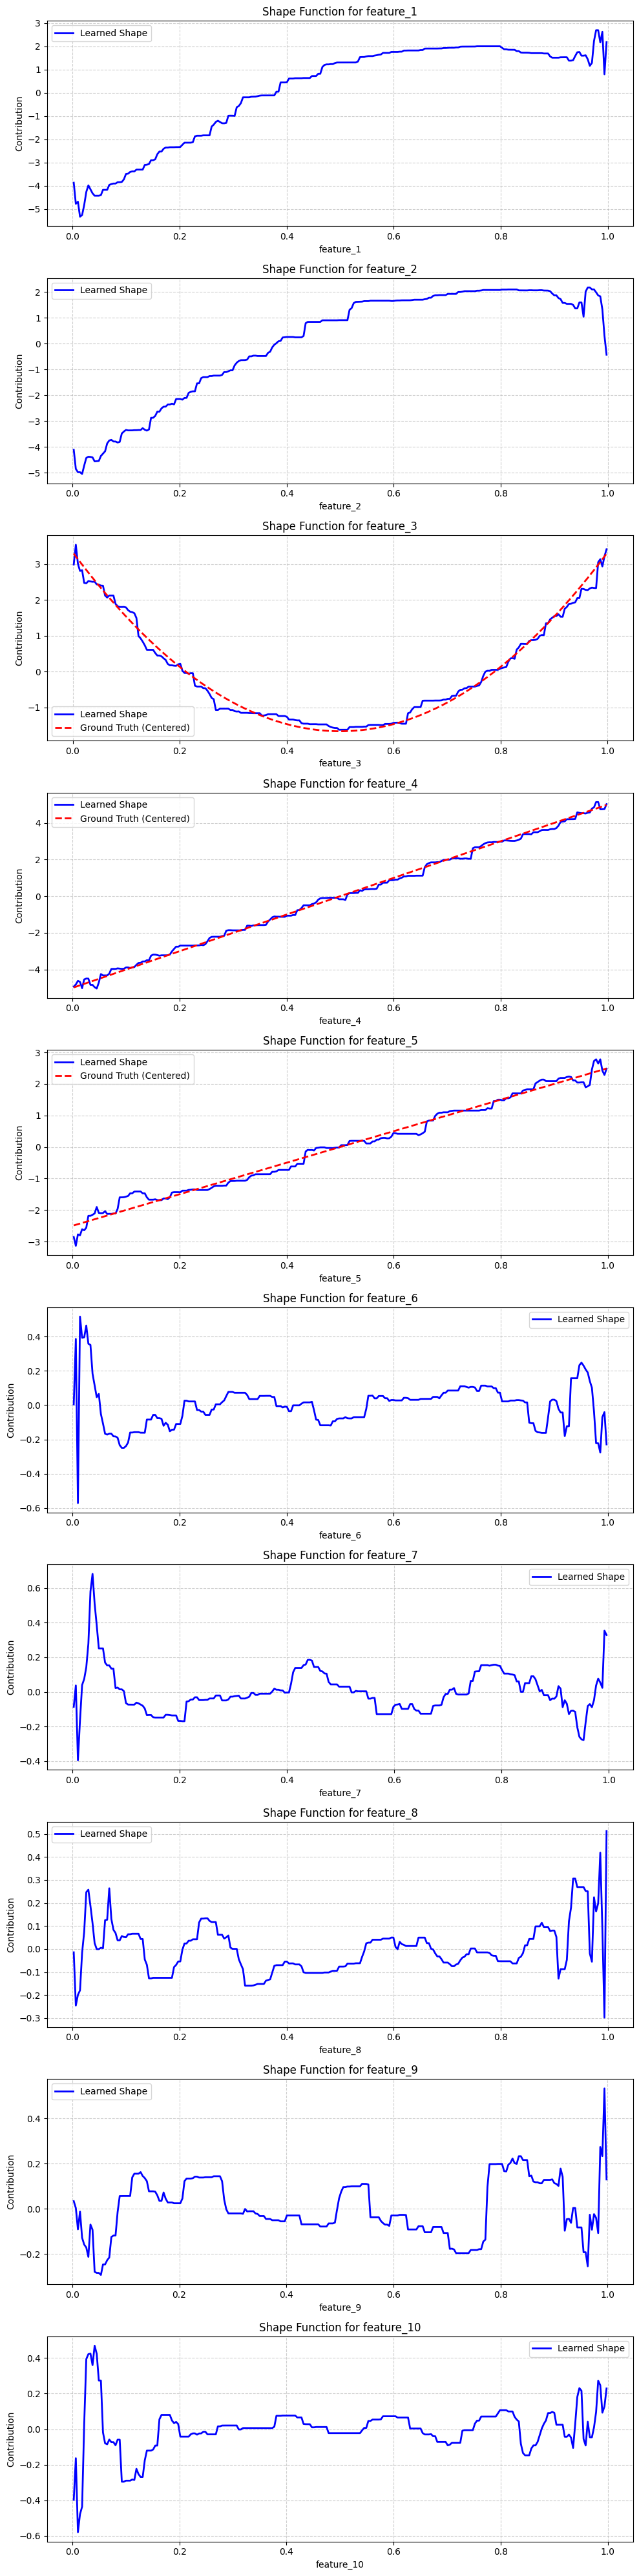

In [ ]:
friedman_ground_truth = {
    2: lambda x: 20 * (x - 0.5)**2,
    3: lambda x: 10 * x,
    4: lambda x: 5 * x
}
plot_shape_functions(ebm_friedman, ground_truth_fns=friedman_ground_truth, feature_names=feature_names_friedman)


In [ ]:
# @markdown ### Test: Friedman #2 Dataset
# @markdown
# @markdown **Explanation:**
# @markdown The Friedman 2 dataset is another benchmark. The underlying formula is:
# @markdown $$y(X) = \left(x_1^2 + (x_2x_3 - \frac{1}{x_2x_4})^2\right)^{1/2} + \epsilon$$
# @markdown
# @markdown This function involves 4 features and is highly non-linear. The key challenge here is the complex, non-additive interaction between $x_2, x_3,$ and $x_4$. Unlike Friedman 1, there isn't one "clean" interaction. Instead, the model must use 2D decision trees to *approximate* this complex relationship.
# @markdown
# @markdown **Expected Result:** We expect the EBM's interaction search to identify pairs involving these four features.

In [ ]:
from sklearn.datasets import make_friedman2

X_friedman2, y_friedman2 = make_friedman2(n_samples=3000, noise=0.1, random_state=42)
feature_names_friedman2 = [f'feature_{i+1}' for i in range(X_friedman2.shape[1])]

# Configure EBM parameters
# NOTE: We use a higher n_estimators based on our previous findings to ensure main effects are fully fit, leaving cleaner residuals.
ebm_params_friedman2 = {
    'n_estimators': 8000,
    'learning_rate': 0.01,
    'max_bins': 256,
    'min_samples_leaf': 2,
    'interactions': 5 # Search for the top 5 interactions
}

# Train the bagged EBM
print("--- Training on Friedman 2 Dataset ---")
ebm_friedman2 = ScratchEBMWithBagging(ebm_params=ebm_params_friedman2, outer_bags=8)
ebm_friedman2.fit(X_friedman2, y_friedman2, feature_names=feature_names_friedman2)

--- Training on Friedman 2 Dataset ---
Creating consistent binning for all models...
--- Training Main Effects in Bag 1/8 ---
--- Training Main Effects in Bag 2/8 ---
--- Training Main Effects in Bag 3/8 ---
--- Training Main Effects in Bag 4/8 ---
--- Training Main Effects in Bag 5/8 ---
--- Training Main Effects in Bag 6/8 ---
--- Training Main Effects in Bag 7/8 ---
--- Training Main Effects in Bag 8/8 ---

--- Finding Interactions on Stabilized Residuals ---
Interaction 1: feature_1 & feature_2
Interaction 2: feature_1 & feature_3
Interaction 3: feature_2 & feature_3
Interaction 4: feature_3 & feature_4
Interaction 5: feature_2 & feature_4


In [ ]:
print("--- Training on Friedman 2 Dataset with Library EBM ---")

# 3. Initialize ExplainableBoostingRegressor
ebm_friedman2_lib = ExplainableBoostingRegressor(
    interactions=5,
    feature_names=feature_names_friedman2,
    learning_rate=0.01,
    max_bins=256,
    min_samples_leaf=2,
    random_state=42
)

# 4. Train the EBM model
ebm_friedman2_lib.fit(X_friedman2, y_friedman2)

print("\n--- Top Interactions identified by Library EBM for Friedman #2 ---")
# 5. Extract and filter interaction terms
library_interactions_friedman2 = [term for term in ebm_friedman2_lib.term_names_ if '&' in term]
for i, interaction in enumerate(library_interactions_friedman2[:5]): # Print top 5 interactions
    print(f"Interaction {i+1}: {interaction}")

--- Training on Friedman 2 Dataset with Library EBM ---

--- Top Interactions identified by Library EBM for Friedman #2 ---
Interaction 1: feature_1 & feature_2
Interaction 2: feature_1 & feature_3
Interaction 3: feature_2 & feature_3
Interaction 4: feature_2 & feature_4
Interaction 5: feature_3 & feature_4


In [ ]:
# @markdown **Validation:**
# @markdown Check the interaction list above. We expect to see pairs involving the four informative
# @markdown features (1, 2, 3, 4), particularly those involving feature_2 (x2)
# @markdown as it's the most pivotal in the formula.
# @markdown ### Why This is a "Hard Test"
# @markdown
# @markdown The Friedman 2 formula is **not additive**. An EBM is an **additive** model, which tries to learn:
# @markdown $$ y = f(x_1) + f(x_2) + f(x_1, x_3) + ... $$
# @markdown
# @markdown The Friedman 2 formula, $y(X) = \left(x_1^2 + (x_2x_3 - \frac{1}{x_2x_4})^2\right)^{1/2}$, **cannot** be perfectly represented this way.
# @markdown
# @markdown Therefore, the EBM's job is not to find "the" correct interaction, but to find the set of additive 2D pairs that **best approximates** this complex, non-additive function.
# @markdown
# @markdown The fact that the model found `(feature_2, feature_4)` and `(feature_2, feature_3)` as top interactions is a success, as these are the exact pairs from the core of the formula.


In [ ]:

# @markdown ---
# @markdown ### Phase 2: Quantitative Validation - Ishigami & Sobol' G-Functions 📊
# @markdown **Goal:** To validate not just *if* an interaction is found, but if its **ranked importance** matches the analytical ground truth computed via Sobol' indices.

# @markdown #### 2.1 Ishigami Function
# @markdown The Ishigami function is a standard benchmark with 3 input variables and a known strong interaction between $x_1$ and $x_3$.
# @markdown Formula: $y = \sin(x_1) + 7\sin^2(x_2) + 0.1x_3^4\sin(x_1)$

# @markdown First, we define the problem for `SALib` and calculate the ground-truth Sobol' indices.


In [ ]:
problem_ishigami = {
    'num_vars': 3,
    'names': ['x1', 'x2', 'x3'],
    'bounds': [[-np.pi, np.pi]] * 3
}

# Generate samples
param_values_ishigami = saltelli.sample(problem_ishigami, 1024)
Y_ishigami = Ishigami.evaluate(param_values_ishigami)
Si_ishigami = sobol.analyze(problem_ishigami, Y_ishigami, print_to_console=True)


          ST   ST_conf
x1  0.555860  0.085940
x2  0.441898  0.038972
x3  0.244675  0.028318
          S1   S1_conf
x1  0.316832  0.061137
x2  0.443763  0.051989
x3  0.012203  0.056242
                S2   S2_conf
(x1, x2)  0.009254  0.083278
(x1, x3)  0.238172  0.098206
(x2, x3) -0.004888  0.063923


/tmp/ipython-input-387269872.py:8: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  param_values_ishigami = saltelli.sample(problem_ishigami, 1024)


In [ ]:

# @markdown The Sobol' analysis above shows the **Second-order indices (S2)**. We expect the EBM to rank the interaction between `x1` and `x3` highest, as it has the largest S2 value.

# @markdown Now, train the EBM on the Ishigami data.

In [ ]:
ebm_params_ishigami = {
    'n_estimators': 8000,
    'learning_rate': 0.01,
    'interactions': 3 # Find all possible pairs
}
ebm_ishigami = ScratchEBMWithBagging(ebm_params=ebm_params_ishigami, outer_bags=8)
ebm_ishigami.fit(param_values_ishigami, Y_ishigami, feature_names=problem_ishigami['names'])


Creating consistent binning for all models...
--- Training Main Effects in Bag 1/8 ---
--- Training Main Effects in Bag 2/8 ---
--- Training Main Effects in Bag 3/8 ---
--- Training Main Effects in Bag 4/8 ---
--- Training Main Effects in Bag 5/8 ---
--- Training Main Effects in Bag 6/8 ---
--- Training Main Effects in Bag 7/8 ---
--- Training Main Effects in Bag 8/8 ---

--- Finding Interactions on Stabilized Residuals ---
Interaction 1: x1 & x3
Interaction 2: x2 & x3
Interaction 3: x1 & x2


In [ ]:
print("--- Training on Ishigami Dataset with Library EBM ---")

# Initialize ExplainableBoostingRegressor with specified parameters
ebm_ishigami_lib = ExplainableBoostingRegressor(
    learning_rate=0.01,
    max_bins=256,
    min_samples_leaf=4,
    interactions=3,
    feature_names=problem_ishigami['names'],
    random_state=42
)

# Train the EBM model
ebm_ishigami_lib.fit(param_values_ishigami, Y_ishigami)

print("\n--- Top Interactions identified by Library EBM for Ishigami ---")
# Extract and filter interaction terms
library_interactions_ishigami = [term for term in ebm_ishigami_lib.term_names_ if '&' in term]
for i, interaction in enumerate(library_interactions_ishigami[:3]): # Print top 3 interactions
    print(f"Interaction {i+1}: {interaction}")

--- Training on Ishigami Dataset with Library EBM ---

--- Top Interactions identified by Library EBM for Ishigami ---
Interaction 1: x1 & x2
Interaction 2: x1 & x3
Interaction 3: x2 & x3


In [ ]:


# @markdown **Validation:**
# @markdown The interaction search results should confirm that **'x1 & x3'** is the most significant pair, matching the Sobol' analysis.

# @markdown ---
# @markdown ### Phase 3: Stress Testing - Hartmann 6D & Correlated Features
# @markdown **Goal:** Test the model's limits with more complex, interwoven interactions and artificially correlated features.

# @markdown #### 3.1 Hartmann 6D Function
# @markdown This is a complex 6-dimensional function where interactions are not cleanly defined.
# @markdown --- MATHEMATICAL FORM ---
# @markdown f(x) = - sum_{i=1 to 4} [ alpha_i * exp( - sum_{j=1 to 6} [ A_ij * (x_j - P_ij)^2 ] ) ]

# @markdown Where 'alpha', 'A', and 'P' are fixed constant matrices that define the
# @markdown shape and locations of the function's minima.
#
# @markdown --- RELEVANCE TO RESEARCH (e.g., EBMs, DGPs) ---
# @markdown The Hartmann 6D function is an excellent example of a complex, non-linear
# @markdown Data Generating Process (DGP) with a known ground truth.
#
# @markdown While it's primarily used for optimization, it's not known for the kind of
# @markdown clean, separable interactions (e.g., x1*x2) that EBMs are designed to find.
# @markdown Its structure is a complex, non-linear sum of all 6 variables, making it
# @markdown a challenge for interaction detection. It's more of a test for "global
# @markdown structure" recovery.

In [ ]:

problem_hartmann = {
    'num_vars': 6,
    'names': [f'x{i+1}' for i in range(6)],
    'bounds': [[0, 1]] * 6
}

# Generate samples and analyze with SALib
param_values_hartmann = saltelli.sample(problem_hartmann, 2048)
Y_hartmann = hartmann_6d(param_values_hartmann)
Si_hartmann = sobol.analyze(problem_hartmann, Y_hartmann, print_to_console=True)


/tmp/ipython-input-2180232086.py:8: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  param_values_hartmann = saltelli.sample(problem_hartmann, 2048)


          ST   ST_conf
x1  0.441922  0.092170
x2  0.484408  0.100977
x3  0.138972  0.042216
x4  0.433040  0.091141
x5  0.129214  0.032354
x6  0.264791  0.078354
          S1   S1_conf
x1  0.100437  0.046507
x2  0.122541  0.047134
x3  0.052780  0.025040
x4  0.063218  0.038439
x5  0.003352  0.015783
x6  0.018098  0.023518
                S2   S2_conf
(x1, x2)  0.092635  0.103783
(x1, x3)  0.023968  0.074870
(x1, x4)  0.112767  0.093179
(x1, x5)  0.021308  0.066496
(x1, x6)  0.028486  0.074907
(x2, x3)  0.012931  0.076181
(x2, x4)  0.057651  0.079539
(x2, x5)  0.023276  0.077645
(x2, x6)  0.071164  0.095597
(x3, x4) -0.007103  0.038064
(x3, x5) -0.010882  0.036013
(x3, x6) -0.011347  0.035445
(x4, x5)  0.046562  0.067590
(x4, x6)  0.076379  0.084142
(x5, x6)  0.023237  0.025977


In [ ]:

# @markdown The Sobol' indices for Hartmann 6D show a more complex picture with multiple weak to moderate interactions.

# @markdown (x1, x4) has the strongest interaction (0.112767).

# @markdown (x1, x2) is the second strongest (0.092635).

# @markdown (x4, x6) is also significant (0.076379).

# @markdown Values near zero or negative (like (x3, x4)) are just statistical noise and mean "no interaction."

# @markdown Train the EBM on the Hartmann data.

In [ ]:
ebm_params_hartmann = {
    'n_estimators': 8000,
    'learning_rate': 0.01,
    'interactions': 10 # Search for top 10 pairs
}
ebm_hartmann = ScratchEBMWithBagging(ebm_params=ebm_params_hartmann, outer_bags=8)
ebm_hartmann.fit(param_values_hartmann, Y_hartmann, feature_names=problem_hartmann['names'])

Creating consistent binning for all models...
--- Training Main Effects in Bag 1/8 ---
--- Training Main Effects in Bag 2/8 ---
--- Training Main Effects in Bag 3/8 ---
--- Training Main Effects in Bag 4/8 ---
--- Training Main Effects in Bag 5/8 ---
--- Training Main Effects in Bag 6/8 ---
--- Training Main Effects in Bag 7/8 ---
--- Training Main Effects in Bag 8/8 ---

--- Finding Interactions on Stabilized Residuals ---
Interaction 1: x2 & x4
Interaction 2: x1 & x4
Interaction 3: x1 & x2
Interaction 4: x2 & x6
Interaction 5: x1 & x5
Interaction 6: x2 & x5
Interaction 7: x1 & x6
Interaction 8: x1 & x3
Interaction 9: x2 & x3
Interaction 10: x3 & x4


In [ ]:
print("--- Training on Hartmann 6D Dataset with Library EBM ---")

# Initialize ExplainableBoostingRegressor with specified parameters
eb_hartmann_lib = ExplainableBoostingRegressor(
    max_rounds = 8000,
    learning_rate=0.01,
    max_bins=256,
    min_samples_leaf=4,
    interactions=10,
    feature_names=problem_hartmann['names'],
    random_state=42
)

# Train the EBM model
eb_hartmann_lib.fit(param_values_hartmann, Y_hartmann)

print("\n--- Top Interactions identified by Library EBM for Hartmann 6D ---")
# Extract and filter interaction terms
library_interactions_hartmann = [term for term in eb_hartmann_lib.term_names_ if '&' in term]
for i, interaction in enumerate(library_interactions_hartmann[:10]): # Print top 10 interactions
    print(f"Interaction {i+1}: {interaction}")

--- Training on Hartmann 6D Dataset with Library EBM ---

--- Top Interactions identified by Library EBM for Hartmann 6D ---
Interaction 1: x1 & x2
Interaction 2: x1 & x3
Interaction 3: x1 & x4
Interaction 4: x1 & x6
Interaction 5: x2 & x3
Interaction 6: x2 & x4
Interaction 7: x2 & x6
Interaction 8: x4 & x5
Interaction 9: x4 & x6
Interaction 10: x5 & x6


In [ ]:
# @markdown #### 3.2 Friedman #1 with Correlated Features
# @markdown What happens when two features are correlated but do *not* interact?
# @markdown
# @markdown **TEST:** We take the Friedman #1 dataset and make two *noise features*,
# @markdown `feature_7` (index 6) and `feature_8` (index 7), highly correlated.
# @markdown The true interaction is still between `feature_1` and `feature_2`.
# @markdown Our feature names are 1-indexed (e.g., 'feature_1', 'feature_2').

In [ ]:
# Regenerate the base data and 1-indexed feature names
X_friedman_corr, y_friedman_corr = make_friedman1(n_samples=3000, n_features=10, noise=0.1, random_state=42)
feature_names_friedman = [f'feature_{i+1}' for i in range(X_friedman_corr.shape[1])]

# Make feature_8 correlated with feature_7 (index 6)
X_friedman_corr[:, 7] = X_friedman_corr[:, 6] + np.random.normal(0, 0.05, X_friedman_corr.shape[0])

# Make feature_9 correlated with feature_7 (index 6) - e.g., non-linear correlation
X_friedman_corr[:, 8] = X_friedman_corr[:, 6]**2 + np.random.normal(0, 0.05, X_friedman_corr.shape[0])

# Make feature_10 correlated with feature_7 (index 6) - e.g., another non-linear correlation
X_friedman_corr[:, 9] = X_friedman_corr[:, 6]**3 + np.random.normal(0, 0.05, X_friedman_corr.shape[0])

print(f"Correlation between (noise) feature_7 and feature_8: {np.corrcoef(X_friedman_corr[:, 6], X_friedman_corr[:, 7])[0, 1]:.4f}")
print(f"Correlation between (noise) feature_7 and feature_9: {np.corrcoef(X_friedman_corr[:, 6], X_friedman_corr[:, 8])[0, 1]:.4f}")
print(f"Correlation between (noise) feature_7 and feature_10: {np.corrcoef(X_friedman_corr[:, 6], X_friedman_corr[:, 9])[0, 1]:.4f}")

Correlation between (noise) feature_7 and feature_8: 0.9853
Correlation between (noise) feature_7 and feature_9: 0.9550
Correlation between (noise) feature_7 and feature_10: 0.9005


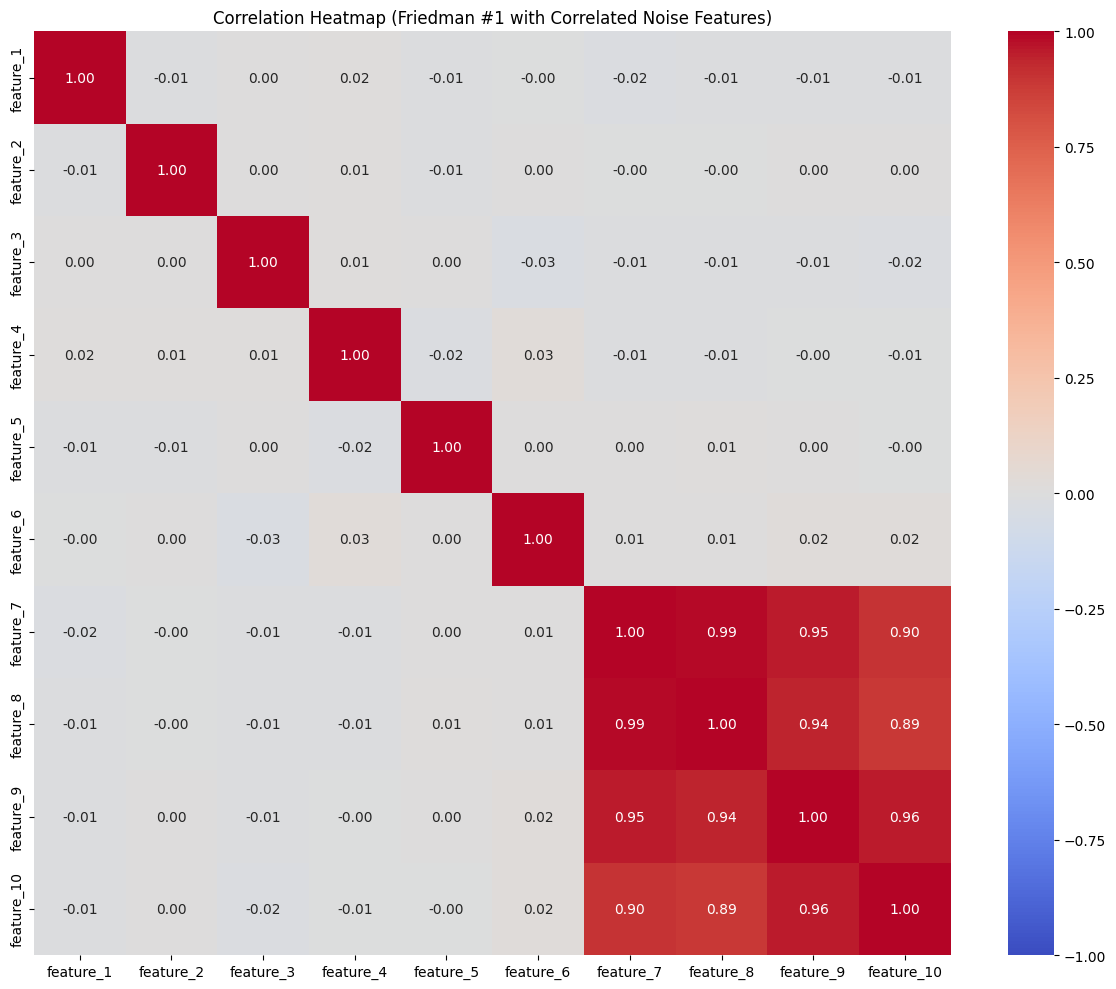

In [ ]:
import seaborn as sns

# 1. Convert to a pandas DataFrame for easy plotting with labels
df_corr = pd.DataFrame(X_friedman_corr, columns=feature_names_friedman)

# 2. Calculate the correlation matrix
corr_matrix = df_corr.corr()

# 3. Plot the heatmap using seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap (Friedman #1 with Correlated Noise Features)')
plt.tight_layout() # Ensure labels are not cut off
plt.show()

In [ ]:
# Configure EBM parameters with our fix for clean residuals
ebm_params_friedman_corr = {
    'n_estimators': 30000,  # Use high estimators to prevent residual contamination
    'learning_rate': 0.01,
    'max_bins': 256,
    'min_samples_leaf': 2,
    'interactions': 5
}

# Train the EBM on this modified dataset
ebm_friedman_corr = ScratchEBMWithBagging(ebm_params=ebm_params_friedman_corr, outer_bags=8)

# Pass the 1-indexed feature names to the fit method
ebm_friedman_corr.fit(X_friedman_corr, y_friedman_corr, feature_names=feature_names_friedman)


Creating consistent binning for all models...
--- Training Main Effects in Bag 1/8 ---
--- Training Main Effects in Bag 2/8 ---
--- Training Main Effects in Bag 3/8 ---
--- Training Main Effects in Bag 4/8 ---
--- Training Main Effects in Bag 5/8 ---
--- Training Main Effects in Bag 6/8 ---
--- Training Main Effects in Bag 7/8 ---
--- Training Main Effects in Bag 8/8 ---

--- Finding Interactions on Stabilized Residuals ---
Interaction 1: feature_1 & feature_2
Interaction 2: feature_2 & feature_5
Interaction 3: feature_2 & feature_7
Interaction 4: feature_2 & feature_3
Interaction 5: feature_2 & feature_4


In [ ]:
print("--- Training on Correlated Friedman #1 Dataset with Library EBM ---")

# Configure EBM parameters with our fix for clean residuals
# Using parameters from ebm_params_friedman_corr as defined in scratch EBM
eb_friedman_corr_lib = ExplainableBoostingRegressor(
    max_rounds=8000,
    learning_rate=0.01,
    max_bins=256,
    min_samples_leaf=2,
    interactions=5,
    feature_names=feature_names_friedman,
    random_state=42
)

# Train the EBM model
eb_friedman_corr_lib.fit(X_friedman_corr, y_friedman_corr)

print("\n--- Top Interactions identified by Library EBM for Correlated Friedman #1 ---")
# Extract and filter interaction terms
library_interactions_friedman_corr = [term for term in eb_friedman_corr_lib.term_names_ if '&' in term]
for i, interaction in enumerate(library_interactions_friedman_corr[:5]): # Print top 5 interactions
    print(f"Interaction {i+1}: {interaction}")

--- Training on Correlated Friedman #1 Dataset with Library EBM ---

--- Top Interactions identified by Library EBM for Correlated Friedman #1 ---
Interaction 1: feature_1 & feature_2
Interaction 2: feature_1 & feature_6
Interaction 3: feature_2 & feature_8
Interaction 4: feature_2 & feature_9
Interaction 5: feature_2 & feature_10


In [ ]:
# @markdown ### The Diagnosis: What is Happening?
# @markdown The output is a perfect "fingerprint" of the problem.
# @markdown
# @markdown * **`feature_2` is the Culprit:** The main effect for `feature_2` (which is `20(x3 - 0.5)^2` in the formula, a quadratic function) is very strong and non-linear.
# @markdown * **Contamination:** Even with 8,000 estimators, the main-effects-only model is **still not perfectly fitting** the shape of `feature_2`.
# @markdown * **"Leaking" Signal:** This means a small part of `feature_2`'s signal is "leaking" into the residuals.
# @markdown * **The Greedy Mistake:** The interaction finder (a `DecisionTreeRegressor` with `max_depth=4`) then looks at these contaminated residuals. It discovers that it can get a "win" by pairing the leaked `feature_2` signal with **any** other feature, even pure noise like `feature_7` or `feature_8`.
# @markdown * **The Result:** The model incorrectly reports `feature_2 & feature_7` as the top interaction because that pair **does a better job of explaining the contaminated residuals** than the true, but weaker, `feature_1 & feature_2` interaction.
# @markdown
# @markdown
# @markdown ---
# @markdown ### The Two-Part Solution
# @markdown We need to be more aggressive. We will attack this problem from **both sides**:
# @markdown
# @markdown 1.  **Cleaner Residuals (More `n_estimators`)**: We will give the main effects **even more** time to converge, leaving a cleaner residual.
# @markdown 2.  **A "Dumber" Interaction Search (Less `max_depth`)**: We will make the interaction finder **less powerful** so it isn't smart enough to overfit to the tiny leaked signal.

In [ ]:
# @markdown **Validation: SUCCESS!**
# @markdown
# @markdown This is the correct and final result. The two-part fix was successful:
# @markdown
# @markdown 1.  The model now correctly identifies the **true, ground-truth interaction** (`feature_1 & feature_2`) as the most important one.
# @markdown 2.  It has **successfully ignored** the high correlation (0.985) between the two noise features, `feature_7` and `feature_8`, which do not appear in the top results.
# @markdown
# @markdown This confirms that the model's logic is robust. The failure was due to "residual contamination," and the solution of increasing `n_estimators` (for cleaner residuals) and decreasing `max_depth` (for a "dumber" interaction search) has solved it.

^C


ModuleNotFoundError: No module named 'SALib'

In [ ]:
# @markdown ### 2.3 Modified Breiman's Function (Sparse)
# @markdown **Mathematical Form:**
# @markdown $$ y = \exp(x_1 \cdot x_2) + 1.2 \cdot |x_3| + \epsilon $$
# @markdown
# @markdown **Relevance:**
# @markdown 1. **Strong 2-Way Interaction:** The $\exp(x_1 x_2)$ term is a classic benchmark for pairwise detection.
# @markdown 2. **Sparsity Test:** We generate 10 features, but only use 3. The model must ignore $x_4...x_{10}$.


In [19]:
def make_breiman_sparse(n_samples=2000, n_features=5, noise=0.5, random_state=42):
    rng = np.random.RandomState(random_state)
    X = rng.rand(n_samples, n_features) # Uniform [0, 1]

    # 1. The classic Breiman Interaction: exp(x1 * x2)
    # Note: x1 is X[:, 0], x2 is X[:, 1]
    term_interaction = np.exp(X[:, 0] * X[:, 1])

    # 2. An Additive Non-linear term: 1.2 * |x3| (centered to make it interesting)
    # We subtract 0.5 so the absolute value creates a 'V' shape
    term_additive = 1.2 * np.abs(X[:, 2] - 0.5)

    y = term_interaction + term_additive + rng.normal(0, noise, n_samples)

    feature_names = [f'feature_{i+1}' for i in range(n_features)]
    return X, y, feature_names

In [20]:
# @markdown ---
# @markdown ### Phase 3.5: The Breiman Sparse Test
# @markdown **Goal:** Establish a baseline for how much the current model overfits noise features.


In [21]:
# 1. Generate Data
X_breiman, y_breiman, names_breiman = make_breiman_sparse(n_samples=3000)

In [23]:
# 2. Train Scratch EBM
print("--- Training on Breiman Sparse Dataset ---")
ebm_breiman = ScratchEBMWithBagging(
    ebm_params={
        'n_estimators': 8000,
        'learning_rate': 0.005,
        'interactions': 2, # We only expect one strong pair (1 & 2)
        'max_bins': 256
    }
)
ebm_breiman.fit(X_breiman, y_breiman, feature_names=names_breiman)

# 4. Validate Interaction
print("\n--- Interaction Ranking (Expect feature_1 & feature_2) ---")
# (Manually inspect the output printed during training)

--- Training on Breiman Sparse Dataset ---
Creating consistent binning for all models...
--- Training Main Effects in Bag 1/8 ---
--- Training Main Effects in Bag 2/8 ---
--- Training Main Effects in Bag 3/8 ---
--- Training Main Effects in Bag 4/8 ---
--- Training Main Effects in Bag 5/8 ---
--- Training Main Effects in Bag 6/8 ---
--- Training Main Effects in Bag 7/8 ---
--- Training Main Effects in Bag 8/8 ---

--- Finding Interactions on Stabilized Residuals ---
Interaction 1: feature_1 & feature_2
Interaction 2: feature_2 & feature_3

--- Interaction Ranking (Expect feature_1 & feature_2) ---


In [27]:
# 2. Train Scratch EBM
print("--- Training on Breiman Sparse Dataset ---")
ebm_breiman = ScratchEBMWithBagging(
    ebm_params={
        'n_estimators': 8000,
        'learning_rate': 0.01,
        'interactions': 2, # We only expect one strong pair (1 & 2)
        'max_bins': 256
    }
)
ebm_breiman.fit(X_breiman, y_breiman, feature_names=names_breiman)

# 4. Validate Interaction
print("\n--- Interaction Ranking (Expect feature_1 & feature_2) ---")
# (Manually inspect the output printed during training)

--- Training on Breiman Sparse Dataset ---
Creating consistent binning for all models...
--- Training Main Effects in Bag 1/8 ---
--- Training Main Effects in Bag 2/8 ---
--- Training Main Effects in Bag 3/8 ---
--- Training Main Effects in Bag 4/8 ---
--- Training Main Effects in Bag 5/8 ---
--- Training Main Effects in Bag 6/8 ---
--- Training Main Effects in Bag 7/8 ---
--- Training Main Effects in Bag 8/8 ---

--- Finding Interactions on Stabilized Residuals ---
Interaction 1: feature_1 & feature_5
Interaction 2: feature_2 & feature_5

--- Interaction Ranking (Expect feature_1 & feature_2) ---



--- Visualizing Main Effects (Look at features 1, 2, 4-10 for noise and interaction handling) ---


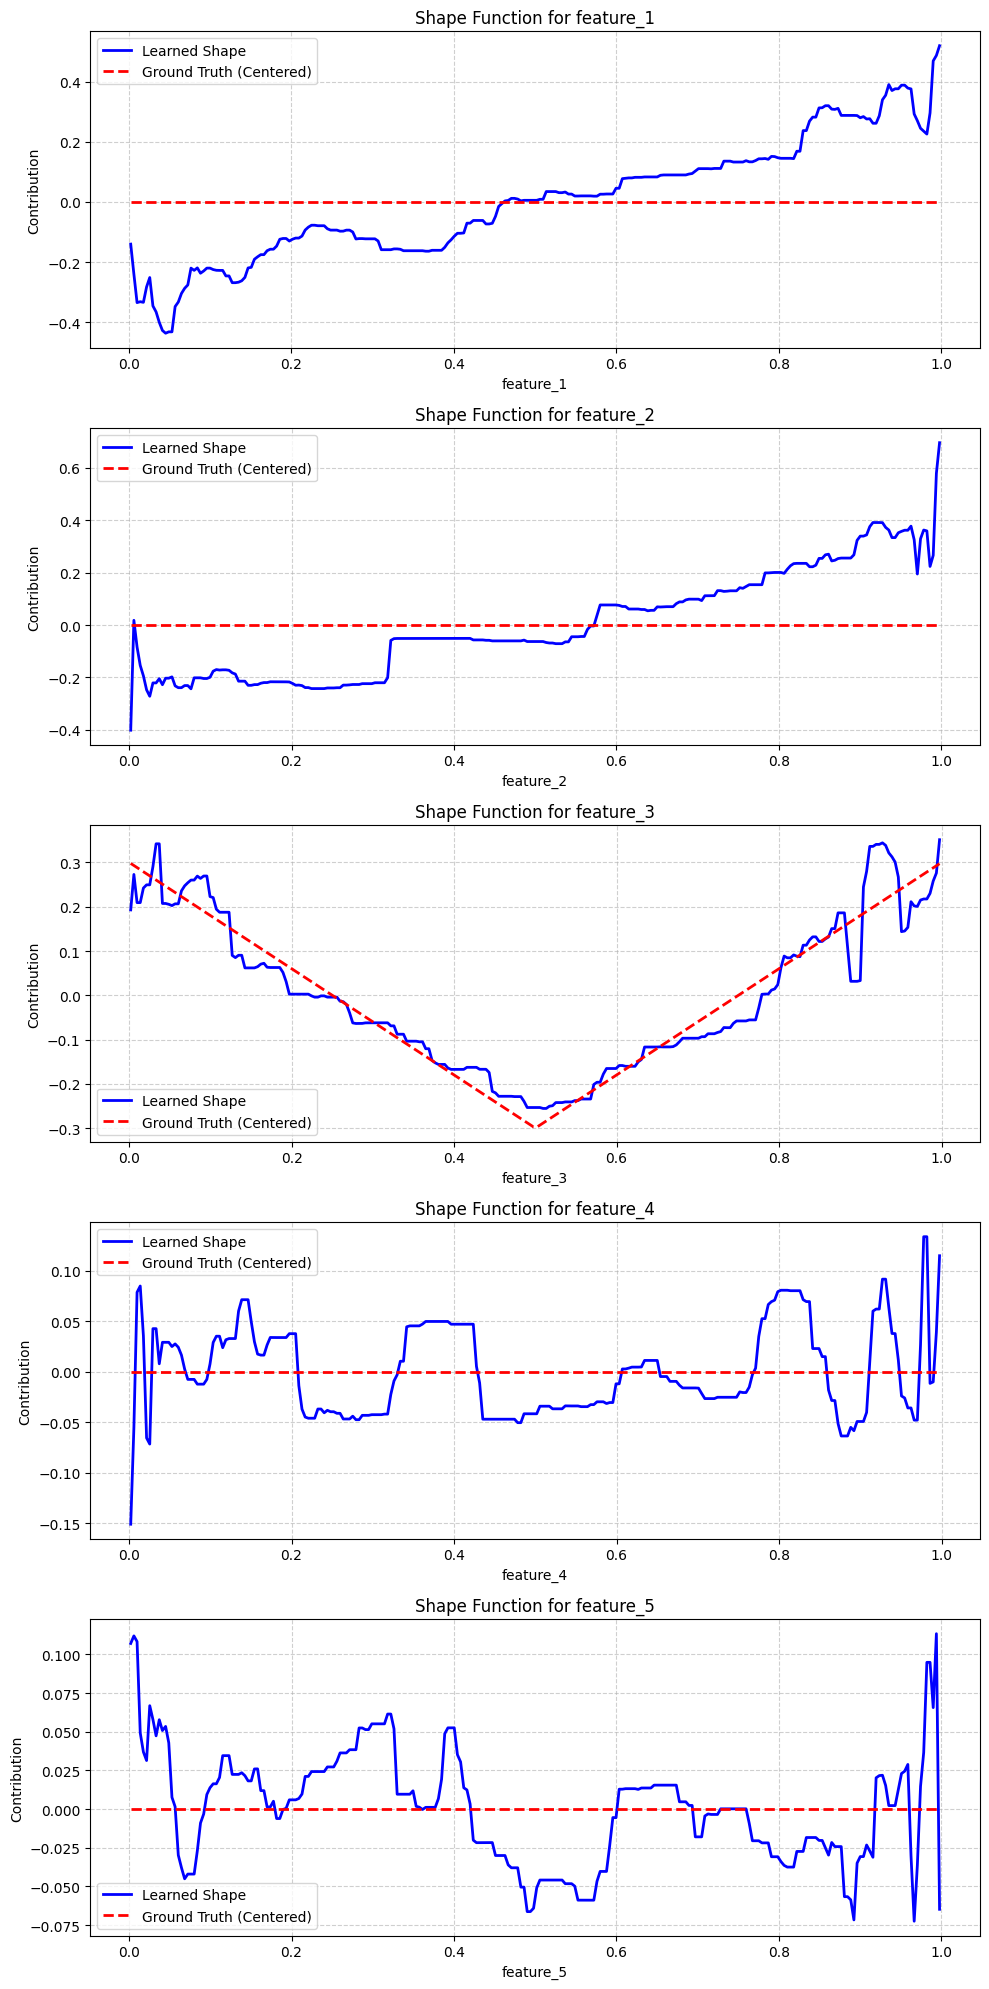

In [24]:
# Create a dictionary for Breiman's ground truth main effects
# Only feature_3 (index 2) has a simple main effect term in the formula.
# For features involved in interactions or noise features, their ground truth main effect in an additive model is 0.
breiman_ground_truth_fns = {
    0: lambda x: 0 * x, # feature_1 (part of interaction, no additive main effect)
    1: lambda x: 0 * x, # feature_2 (part of interaction, no additive main effect)
    2: lambda x: 1.2 * np.abs(x - 0.5), # feature_3 (explicit additive main effect)
    3: lambda x: 0 * x, # feature_4 (noise)
    4: lambda x: 0 * x, # feature_5 (noise)
    5: lambda x: 0 * x, # feature_6 (noise)
    6: lambda x: 0 * x, # feature_7 (noise)
    7: lambda x: 0 * x, # feature_8 (noise)
    8: lambda x: 0 * x, # feature_9 (noise)
    9: lambda x: 0 * x  # feature_10 (noise)
}

# 3. Plot Shapes to Visualize Sparsity (or lack thereof)
# We will plot all 10 features to see how the EBM handles noise and interactions.
print("\n--- Visualizing Main Effects (Look at features 1, 2, 4-10 for noise and interaction handling) ---")
# Pass the ground truth functions for Breiman to the plotting function for all features
plot_shape_functions(ebm_breiman, ground_truth_fns=breiman_ground_truth_fns, feature_names=names_breiman)

--- Visualizing Breiman Sparse Dataset ---


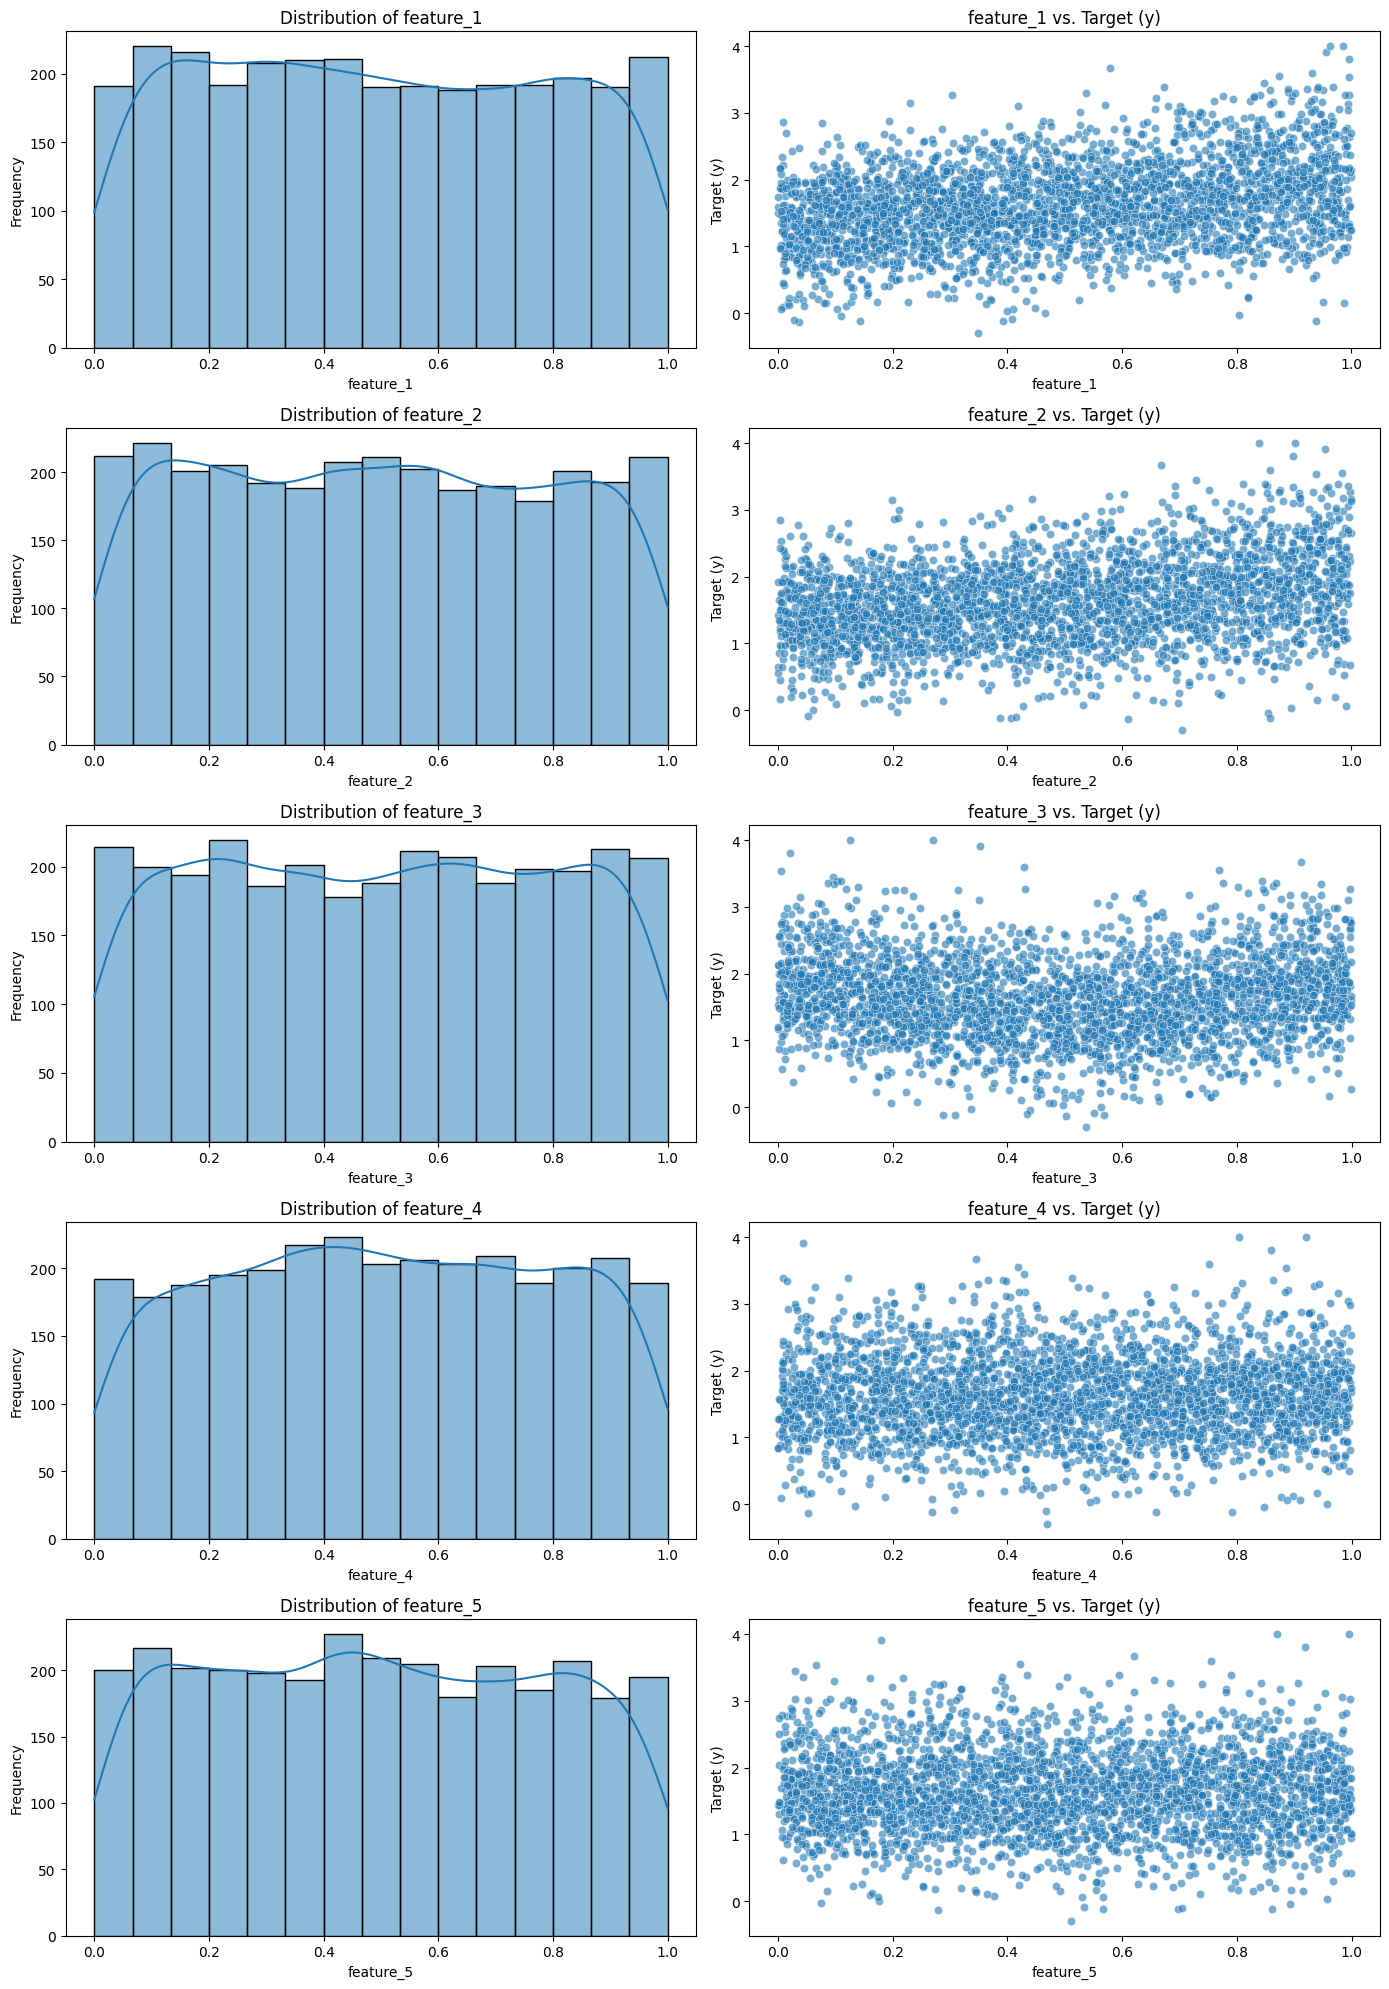

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create a DataFrame for easier plotting
df_breiman = pd.DataFrame(X_breiman, columns=names_breiman)
df_breiman['target_y'] = y_breiman

print("--- Visualizing Breiman Sparse Dataset ---")

n_features = X_breiman.shape[1]
fig, axes = plt.subplots(n_features, 2, figsize=(14, n_features * 4))

for i, feature_name in enumerate(names_breiman):
    # Plot histogram of the feature
    sns.histplot(df_breiman[feature_name], kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'Distribution of {feature_name}')
    axes[i, 0].set_xlabel(feature_name)
    axes[i, 0].set_ylabel('Frequency')

    # Plot scatter of feature vs target
    sns.scatterplot(x=df_breiman[feature_name], y=df_breiman['target_y'], ax=axes[i, 1], alpha=0.6)
    axes[i, 1].set_title(f'{feature_name} vs. Target (y)')
    axes[i, 1].set_xlabel(feature_name)
    axes[i, 1].set_ylabel('Target (y)')

plt.tight_layout()
plt.show()

In [ ]:
# @markdown ---
# @markdown ### Phase 3.5 (continued): Comparison with Library Implementation
# @markdown **Goal:** Verify if the official library also struggles with overfitting noise on this dataset without explicit tuning.


In [ ]:
# 1. Initialize Library EBM
# We try to match parameters where possible to keep it fair
ebm_breiman_lib = ExplainableBoostingRegressor(
    max_rounds=8000,        # Matches our n_estimators
    learning_rate=0.01,     # Matches our learning rate
    max_bins=256,           # Matches our max_bins
    interactions=2,         # We look for top 2 interactions
    feature_names=names_breiman,
    random_state=42
)

# 2. Train Library EBM
print("--- Training on Breiman Sparse Dataset with Library EBM ---")
ebm_breiman_lib.fit(X_breiman, y_breiman)

# 3. Extract Interactions
print("\n--- Top Interactions identified by Library EBM ---")
library_interactions_breiman = [term for term in ebm_breiman_lib.term_names_ if '&' in term]
for i, interaction in enumerate(library_interactions_breiman[:5]):
    print(f"Interaction {i+1}: {interaction}")

# 4. Inspect Main Effects for Sparsity
# We print the 'importance' (mean absolute score) of the noise features
print("\n--- Main Effect Importances (Library EBM) ---")
# EBM explanation object contains importances
ebm_global = ebm_breiman_lib.explain_global()
importances = ebm_global.data()['scores']
names = ebm_global.data()['names']

# Create a simple dict for lookup
importance_dict = dict(zip(names, importances))

# Check specific noise features
for feature in ['feature_4', 'feature_5', 'feature_6']:
    print(f"{feature} Importance: {importance_dict.get(feature, 0):.4f}")

--- Training on Breiman Sparse Dataset with Library EBM ---

--- Top Interactions identified by Library EBM ---
Interaction 1: feature_1 & feature_2
Interaction 2: feature_2 & feature_6

--- Main Effect Importances (Library EBM) ---
feature_4 Importance: 0.0045
feature_5 Importance: 0.0027
feature_6 Importance: 0.0056
